<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Проект "Прогнозирование заказов такси"

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

В данном проекте нам необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


## Подготовка

В данном этапе работы нам необходимо:
- Ознакомиться с имеющимися данными.
- Изменить название и тип столбцов где необходимо.


In [1]:
pip install sweetviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats as st
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             accuracy_score, 
                             f1_score, roc_curve,
                             roc_auc_score,
                             make_scorer)
from sklearn.utils import shuffle
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit

import sweetviz as sv 
from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor

In [4]:
data = pd.read_csv('taxi.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
# изменим тип столбца на datetime
data['datetime'] = pd.to_datetime(data['datetime'])

## Анализ

В течение данного этапа нам необходимо:
- Проверить наличие явных и неявных дубликатов. 
- Удалить или заполнить пропуски.
- Исследовать данные на предмет аномалий и выбросов. Обработать их, где необходимо.
- Исследовать характер распределения данных.
- Произвести ресемплинг по одному часу.
- Разделить датасет на обучающую и тестовую выборки в соотношении 9:1.

In [6]:
# на всякий случай отсортируем все данные по дате
data = data.sort_values(by='datetime')

In [7]:
# проверим наш датасет на предмет дубликатов
data.duplicated().sum()

0

In [8]:
# так как дата и время в нашем случае - это уникальный идентификатор, вынесем их в индекс
data.index = data['datetime']
data = data.drop('datetime', axis=1)

In [9]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


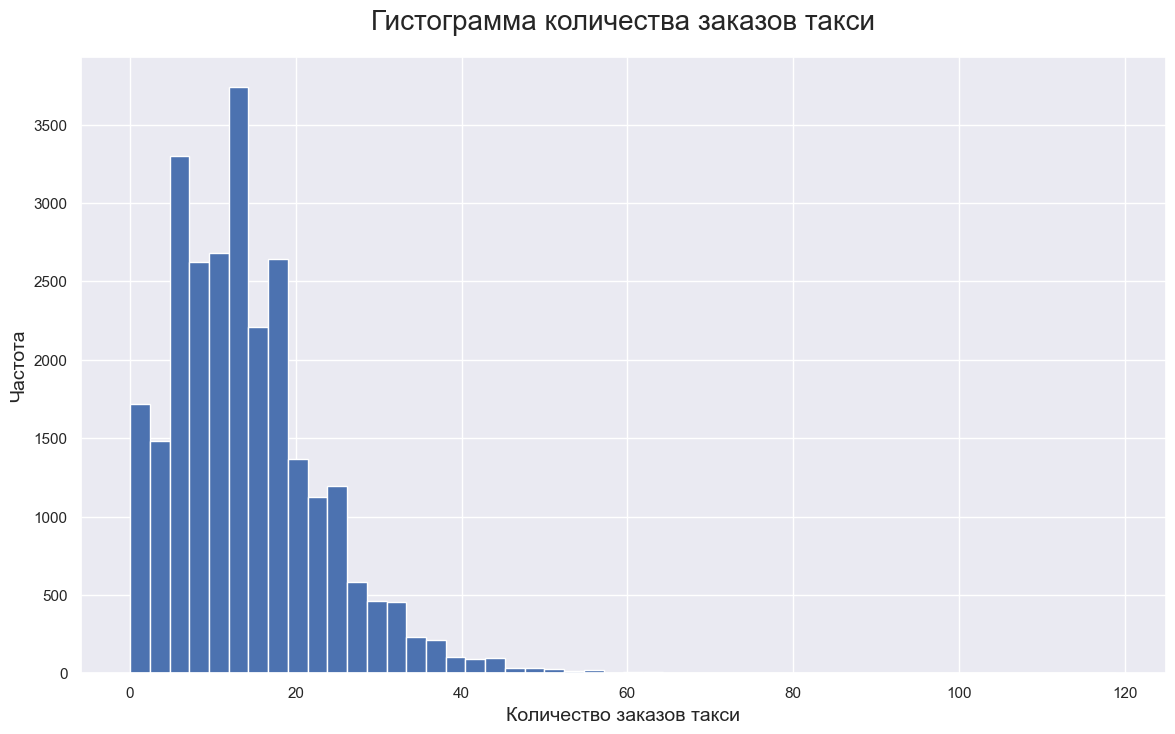

In [10]:
# посмотрим на распределение данных
sns.set_theme(style='darkgrid')

plt.figure(figsize=(14,8))
plt.title(
    'Гистограмма количества заказов такси',
    fontsize='20',
    pad=20
)
plt.hist(data, bins=50)

plt.xlabel('Количество заказов такси', fontsize='14')
plt.ylabel('Частота', fontsize='14')

plt.show()
None

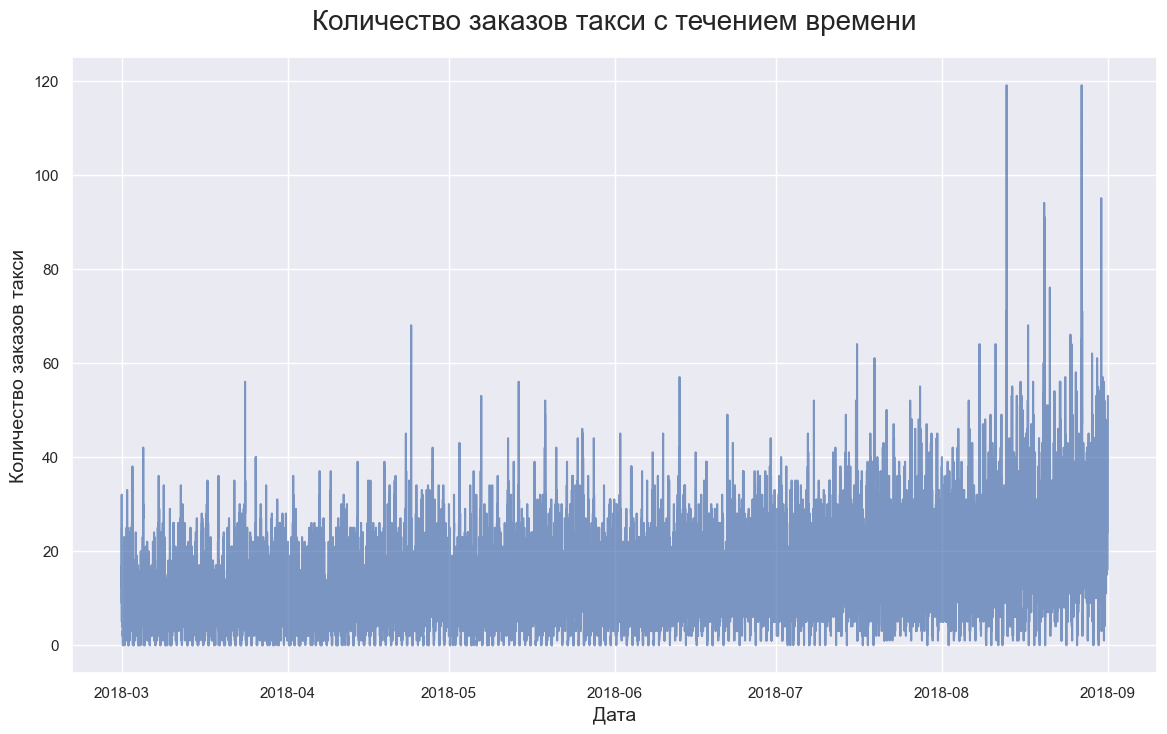

In [11]:
plt.figure(figsize=(14,8))
plt.title(
    'Количество заказов такси с течением времени',
    fontsize='20',
    pad=20
)
plt.plot(data, alpha=0.7)

plt.xlabel('Дата', fontsize='14')
plt.ylabel('Количество заказов такси', fontsize='14')

plt.show()
None

In [12]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [13]:
data.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


In [14]:
# проанализируем особенности нашего временного ряда: тренд, сезонность и остатки

decomposed_full = seasonal_decompose(data)

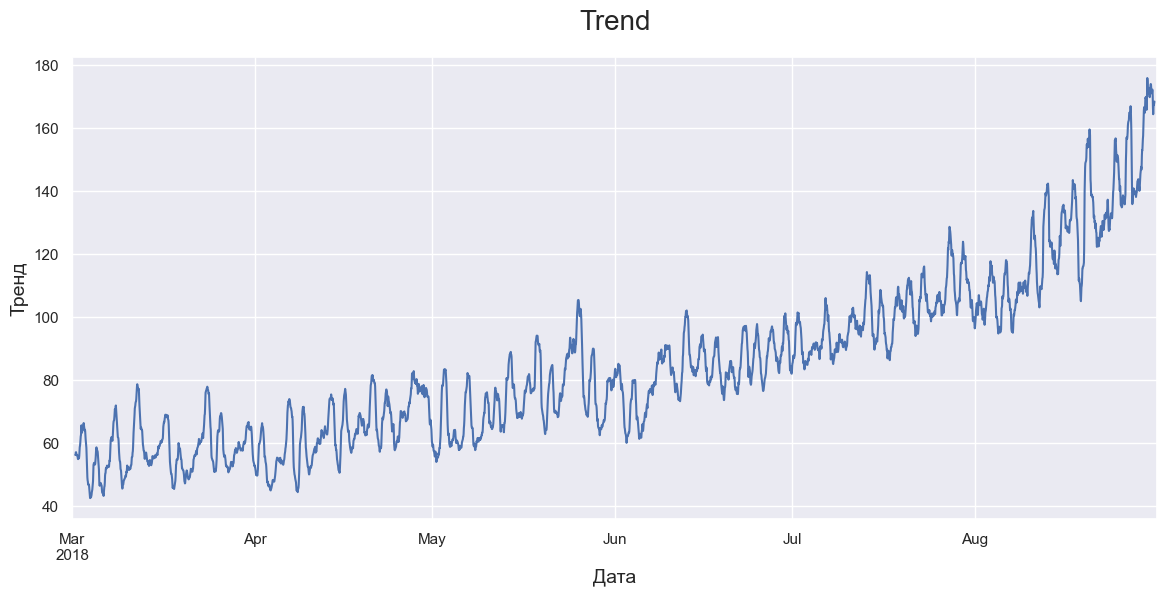

In [15]:
plt.figure(figsize=(14, 6))

decomposed_full.trend.plot()
plt.title('Trend',
        fontsize='20',
        pad=20
         )

plt.xlabel('Дата', fontsize='14')
plt.ylabel('Тренд', fontsize='14')
plt.show()

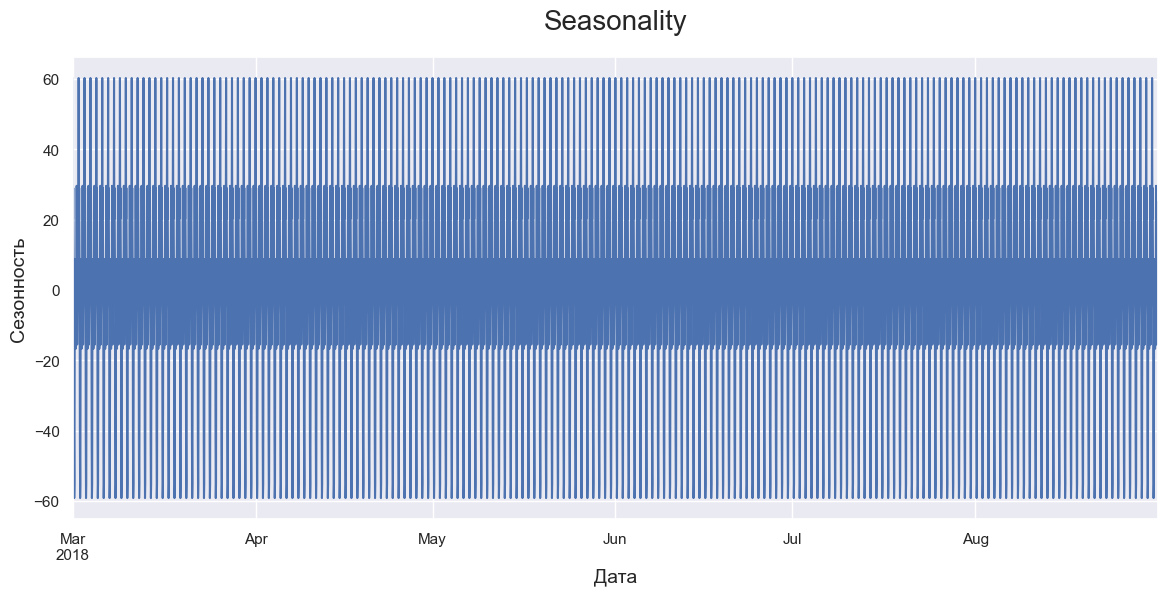

In [16]:
plt.figure(figsize=(14, 6))

decomposed_full.seasonal.plot()
plt.title('Seasonality',
        fontsize='20',
        pad=20
         )

plt.xlabel('Дата', fontsize='14')
plt.ylabel('Сезонность', fontsize='14')
plt.show()

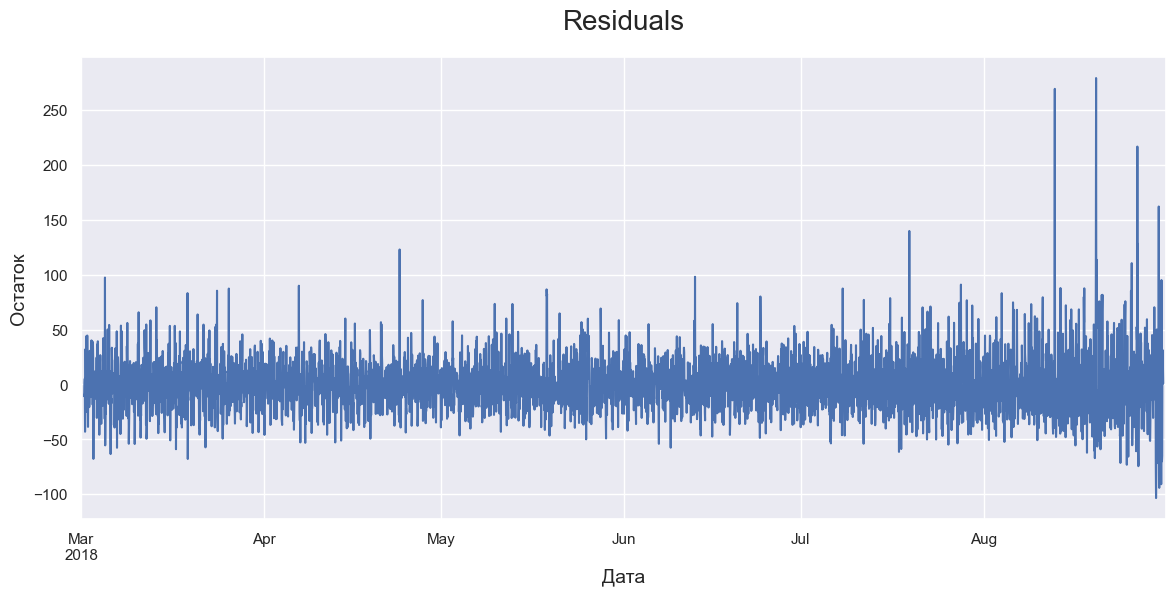

In [17]:
plt.figure(figsize=(14, 6))

decomposed_full.resid.plot(ax=plt.gca())
plt.title('Residuals',
        fontsize='20',
        pad=20
         )

plt.xlabel('Дата', fontsize='14')
plt.ylabel('Остаток', fontsize='14')
plt.show()

На данных графиках мы можем проанализировать тренд и сезонность имеющихся данных.  
Как мы видим, за указанный период, тренд восходящий. С каждым месяцем количество заказов такси из аэропортов постепенно растет. На имеющихся данных, ввиду их ограниченности, сложно сказать, является ли это глобальным трендом (увеличение количества авиарейсов со временем) или это результат годовой сезонности (увеличение авиаперелетов вместе с летним сезоном).

С сезонностью всё несколько сложнее. На масштабе всей выборки сложно увидеть какие-то конкретные паттерны, так как они скорее всего имеют меньший масштаб (например, недели или дни). Попробуем проанализировать 

In [18]:
decomposed_week = seasonal_decompose(data['2018-03-01':'2018-03-07'])

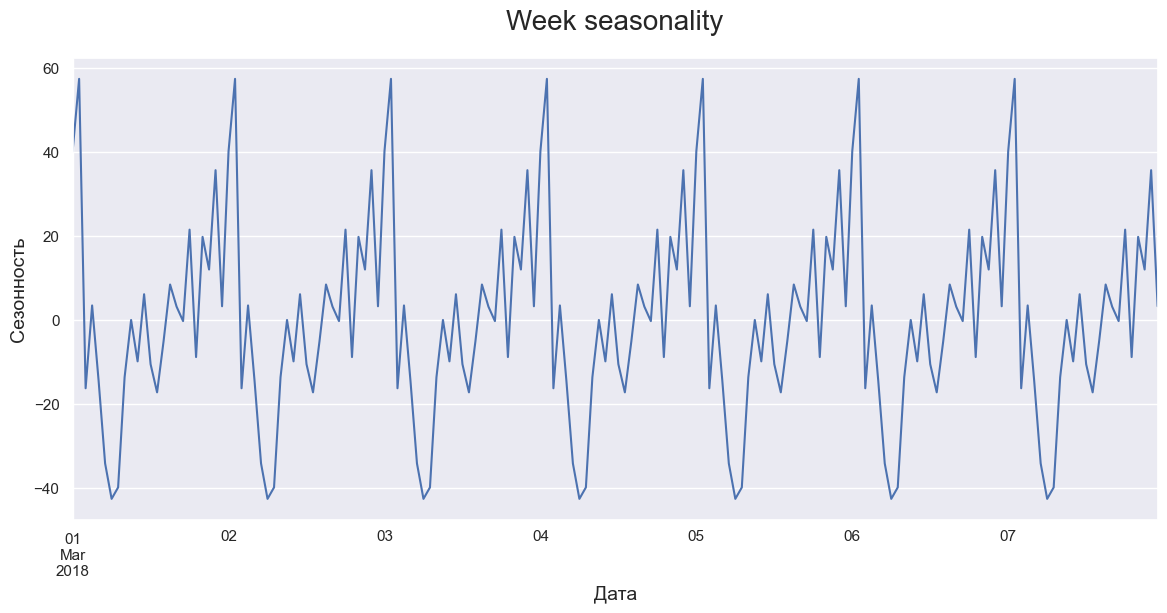

In [19]:
plt.figure(figsize=(14, 6))

decomposed_week.seasonal.plot()
plt.title('Week seasonality',
        fontsize='20',
        pad=20
         )

plt.xlabel('Дата', fontsize='14')
plt.ylabel('Сезонность', fontsize='14')
plt.show()

Как мы видим на масштабе недели, есть четко прослеживающиеся периоды сезонности длительностью примерно в один день.  
Чтобы до конца в этом убедиться, увеличим масштаб до 3 дней.

In [20]:
decomposed_3_days = seasonal_decompose(data['2018-03-01':'2018-03-03'])

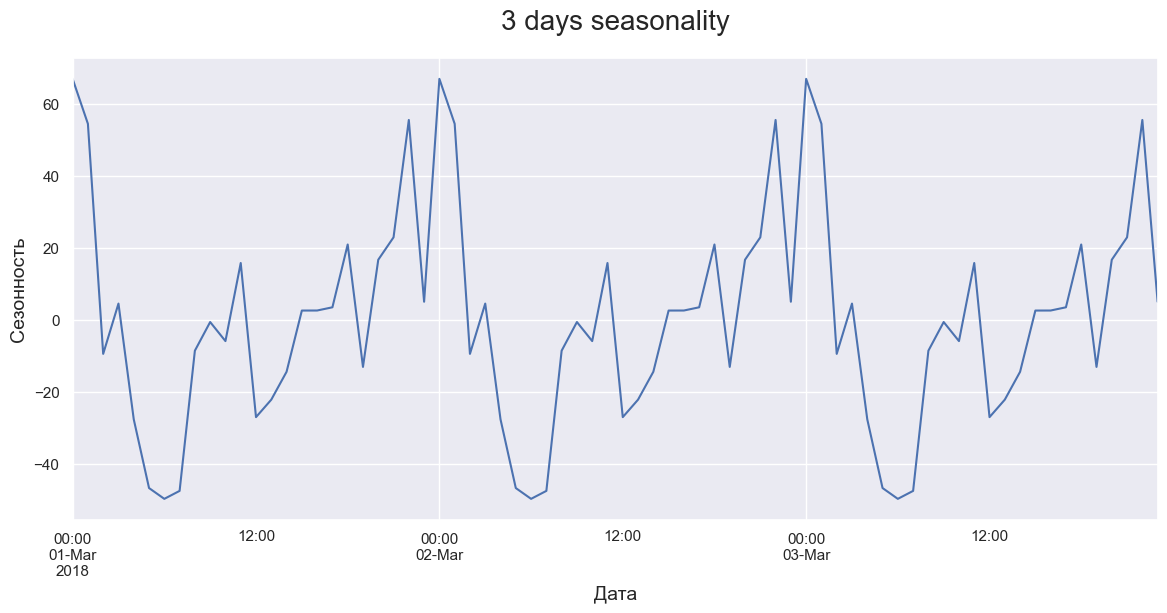

In [21]:
plt.figure(figsize=(14, 6))

decomposed_3_days.seasonal.plot()
plt.title('3 days seasonality',
        fontsize='20',
        pad=20
         )

plt.xlabel('Дата', fontsize='14')
plt.ylabel('Сезонность', fontsize='14')
plt.show()

На мастшабе трёх дней четко прослеживается дневная сезонность количества заказов такси.

Итак мы можем убедиться в том, что пиковые нагрузки в основном преобладают в вечернее время ближе к 00 00, а наименьшая нагрузка - около 5-6 часов утра.

Скорее всего это связано с режимом работы аэропортов и распределения рейсов. Известно, что наибольшая активность приходится на вечерние/ночные часы, когда люди прилетают/вылетают в туристические поездки или возвращаются из командировок после рабочего дня.

In [22]:
# проведем тест Дики-Фуллера для оценки стационарности ряда
# нулевая гипотеза H0 - ряд не стационарен
# альтернативная гипотеза H1 - ряд стационарен
# уровень значимости alpha= 0.05

result = adfuller(data)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.068924
p-value: 0.028940
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


По результатам теста Дики-Фуллера мы видим, что с 5% уровнем значимости мы отвергаем нулевую гипотезу в пользу альтернативной - ряд стационарен.

In [23]:
data_copy = data.copy()
data_copy['rolling_mean'] = data['num_orders'].shift().rolling(5).mean()
data_copy.dropna(inplace=True)

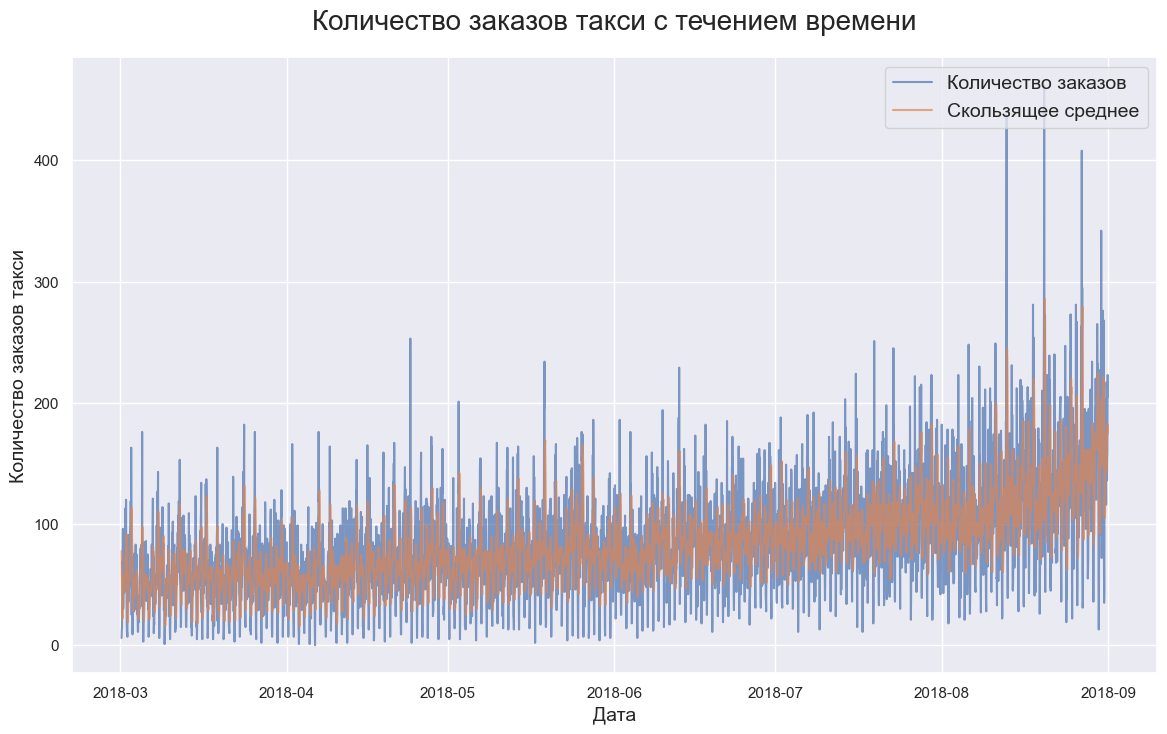

In [24]:
plt.figure(figsize=(14,8))
plt.title(
    'Количество заказов такси с течением времени',
    fontsize='20',
    pad=20
    )
plt.plot(data_copy['num_orders'], alpha=0.7, label='Количество заказов')
plt.plot(data_copy['rolling_mean'], alpha=0.7, label='Скользящее среднее')

plt.xlabel('Дата', fontsize='14')
plt.ylabel('Количество заказов такси', fontsize='14')
plt.legend(loc='upper right', fontsize='14')
plt.show()
None

In [25]:
result = adfuller(data_copy['rolling_mean'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.156888
p-value: 0.022620
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Теперь создадим дополнительные признаки, на которых будет обучаться наша модель.  
Для этого создадим отдельную функцию, чтобы можно было подобрать параметры.

In [26]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    # data_new['year'] = data_new.index.year
    # data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    data_new['hour'] = data_new.index.hour
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_new

In [27]:
data_new = make_features(data, 9, 2)

In [28]:
data_new.info()
data_new.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   day           4416 non-null   int64  
 2   dayofweek     4416 non-null   int64  
 3   hour          4416 non-null   int64  
 4   lag_1         4415 non-null   float64
 5   lag_2         4414 non-null   float64
 6   lag_3         4413 non-null   float64
 7   lag_4         4412 non-null   float64
 8   lag_5         4411 non-null   float64
 9   lag_6         4410 non-null   float64
 10  lag_7         4409 non-null   float64
 11  lag_8         4408 non-null   float64
 12  lag_9         4407 non-null   float64
 13  rolling_mean  4414 non-null   float64
dtypes: float64(10), int64(4)
memory usage: 646.5 KB


,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.5
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,78.0
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,68.5
2018-03-01 05:00:00,6,1,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,54.5
2018-03-01 06:00:00,12,1,3,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,24.5
2018-03-01 07:00:00,15,1,3,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,9.0
2018-03-01 08:00:00,34,1,3,8,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,13.5


In [29]:
# удалим строки с пропусками, образовавшимися после преобразований
data_new = data_new.dropna()
data_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4407 entries, 2018-03-01 09:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4407 non-null   int64  
 1   day           4407 non-null   int64  
 2   dayofweek     4407 non-null   int64  
 3   hour          4407 non-null   int64  
 4   lag_1         4407 non-null   float64
 5   lag_2         4407 non-null   float64
 6   lag_3         4407 non-null   float64
 7   lag_4         4407 non-null   float64
 8   lag_5         4407 non-null   float64
 9   lag_6         4407 non-null   float64
 10  lag_7         4407 non-null   float64
 11  lag_8         4407 non-null   float64
 12  lag_9         4407 non-null   float64
 13  rolling_mean  4407 non-null   float64
dtypes: float64(10), int64(4)
memory usage: 516.4 KB


In [30]:
# теперь нам необходимо выделить целевой признак и остальные, а также разделить наши данные на обучающую и тестовую выборки
features = data_new.drop('num_orders', axis=1)
target = data_new['num_orders']

features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.1,
    shuffle=False,
    random_state=12345
)
display(features_train.shape[0], features_test.shape[0], target_train.shape[0], target_test.shape[0])

3966

441

3966

441

Итак, в течение первых этапов проекта мы:
- Ознакомились с имеющимися данными.
- Изменили тип столбца datetime на datetime.
- Проверили наличие дубликатов - они не были обнаружены. 
- Произвели ресемплинг по одному часу.
- Исследовали данные на предмет аномалий и выбросов и обработали их.
- Исследовали характер распределения данных.
- Создали несколько новых признаков, включая скользящее среднее и отстающие значения.
- Удалили появившиеся пропуски после создания признаков.
- Разделили датасет на обучающую и тестовую выборки в соотношении 9:1.

## Обучение

В данном этапе нам необходимо выбрать несколько моделей, обучить их на имеющихся данных и выбрать наилучшее сочетание метрики качества и полученных гиперпараметров.  

Метрикой качества в данной работе является RMSE.  

В течение данной работы будем тестировать модели дерева решений, случайного леса, LGBM, CatBoost.  
Начнем по порядку.

In [31]:
tss = TimeSeriesSplit(n_splits = 3)

In [33]:
# дерево решений

decision_tree = DecisionTreeRegressor(random_state=12345)

tree_parameters_grid = {
   'max_depth' : range(1, 15)
}

tree_grid_cv_1 = GridSearchCV(
    decision_tree,
    tree_parameters_grid,
    cv=tss,
    scoring = 'neg_mean_squared_error',
    verbose=3
)
tree_grid_cv_1.fit(features_train, target_train)
print(f'Наилучшее значение параметра max_depth: {tree_grid_cv_1.best_params_}') 
print(f'Наилучший показатель RMSE: {(tree_grid_cv_1.best_score_ * (-1))**0.5}')

Fitting 3 folds for each of 14 candidates, totalling 42 fits
[CV 1/3] END ...................max_depth=1;, score=-1061.866 total time=   0.0s
[CV 2/3] END ...................max_depth=1;, score=-1245.986 total time=   0.0s
[CV 3/3] END ...................max_depth=1;, score=-2141.008 total time=   0.0s
[CV 1/3] END ....................max_depth=2;, score=-947.617 total time=   0.0s
[CV 2/3] END ...................max_depth=2;, score=-1082.133 total time=   0.0s
[CV 3/3] END ...................max_depth=2;, score=-1987.517 total time=   0.0s
[CV 1/3] END ....................max_depth=3;, score=-977.654 total time=   0.0s
[CV 2/3] END ...................max_depth=3;, score=-1073.683 total time=   0.0s
[CV 3/3] END ...................max_depth=3;, score=-1818.231 total time=   0.0s
[CV 1/3] END ....................max_depth=4;, score=-868.519 total time=   0.0s
[CV 2/3] END ...................max_depth=4;, score=-1041.386 total time=   0.0s
[CV 3/3] END ...................max_depth=4;, sc

Дерево решений:
- max_depth = 7.
- RMSE = 32,56.

In [34]:
# модель случайного леса

random_forest = RandomForestRegressor(random_state=12345)

forest_parameters_grid = {
    'max_depth' : range(10, 20),
    'n_estimators' : list(map(int, np.linspace(100, 160, 4)))
}

In [35]:
forest_grid_cv = GridSearchCV(
    random_forest,
    forest_parameters_grid,
    cv=tss,
    scoring = 'neg_mean_squared_error',
    verbose=3,
    n_jobs=-1
)
forest_grid_cv.fit(features_train, target_train)
print(f'Наилучшее значение параметра max_depth: {forest_grid_cv.best_params_}') 
print(f'Наилучший показатель RMSE: {(forest_grid_cv.best_score_ * (-1))**0.5}')

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Наилучшее значение параметра max_depth: {'max_depth': 16, 'n_estimators': 120}
Наилучший показатель RMSE: 27.974622307923163


Для модели случайного леса мы получили:
- max_depth=20.
- n_estimators=120.
- RMSE ~ 27,96 что укладывается в наш целевой показатель по эффективности модели (<48)

In [36]:
# Теперь переходим к градиентному бустингу с помощью LGBM

lgbm_model = LGBMRegressor(random_state=12345)

lgbm_parameters_grid = {
    'max_depth' : range(10, 20, 3),
    'n_estimators' : list(map(int, np.linspace(100, 200, 3)))
    #'learning_rate': [0.1, 1.0]
}

lgbm_grid_cv = GridSearchCV(
    lgbm_model,
    lgbm_parameters_grid,
    cv=tss,
    scoring = 'neg_mean_squared_error',
    verbose=3,
    n_jobs=-1
)
lgbm_grid_cv.fit(features_train, target_train)
print(f'Наилучшие значения параметров: {lgbm_grid_cv.best_params_}') 
print(f'Наилучший показатель RMSE: {(lgbm_grid_cv.best_score_ * (-1))**0.5}')

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2028
[LightGBM] [Info] Number of data points in the train set: 3966, number of used features: 13
[LightGBM] [Info] Start training from score 78.359304
Наилучшие значения параметров: {'max_depth': 19, 'n_estimators': 100}
Наилучший показатель RMSE: 27.947139506412093


Итак для модели LGBM мы получили:
- max_depth=14.
- n_estimators=100.
- learning_rate=0.1
- RMSE ~ 27,81 что укладывается в наш целевой показатель по эффективности модели (<48)

In [37]:
# перейдем к последней модели - CatBoost
catboost_model = CatBoostRegressor(random_state=12345, verbose=False)

catboost_parameters_grid = {
    'max_depth' : list(map(int, np.linspace(10, 16, 4))),
    'n_estimators' : list(map(int, np.linspace(100, 200, 3))),
    'learning_rate': [0.1]
}

catboost_grid_cv = GridSearchCV(
    catboost_model,
    catboost_parameters_grid,
    cv=tss,
    scoring = 'neg_mean_squared_error',
    verbose=3,
    n_jobs=-1
)
catboost_grid_cv.fit(features_train, target_train)
print(f'Наилучшие значения параметров: {catboost_grid_cv.best_params_}') 
print(f'Наилучший показатель RMSE: {(catboost_grid_cv.best_score_ * (-1))**0.5}')

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Наилучшие значения параметров: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
Наилучший показатель RMSE: 29.20029600228292


Показатели модели CatBoost:
- max_depth=10.
- n_estimators=150.
- RMSE ~ 30,37, что укладывается в наш целевой показатель по эффективности модели (<48)

По итогам данного этапа мы получили следующие результаты:
- Дерево решений:
    - RMSE ~ 32,47.
- Случайный лес:
    - RMSE ~ 29,28.
- LGBM:
    - RMSE ~ 29,51.
- CatBoost:
    - RMSE ~ 14,79.
    
По результатам обучения наилучший результат RMSE показала модель LGBM.  
Теперь переходим к тестированию выбранной модели на тестовой выборке.


## Тестирование

In [38]:
# проверим выбранную модель на тестовой выборке

lgbm_model = LGBMRegressor(max_depth=14, n_estimators=100, learning_rate=0.1, random_state=12345)

lgbm_model.fit(features_train, target_train)
lgbm_pred = lgbm_model.predict(features_test)

rmse = mean_squared_error(target_test, lgbm_pred, squared=False)

a = lgbm_model.score(features_test, target_test)

print(f'Показатель RMSE: {rmse}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2028
[LightGBM] [Info] Number of data points in the train set: 3966, number of used features: 13
[LightGBM] [Info] Start training from score 78.359304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

E:\Anaconda\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [39]:
target_test.shape[0] #lgbm_pred

441

In [41]:
lgbm_pred = pd.DataFrame(lgbm_pred, index=target_test.index)

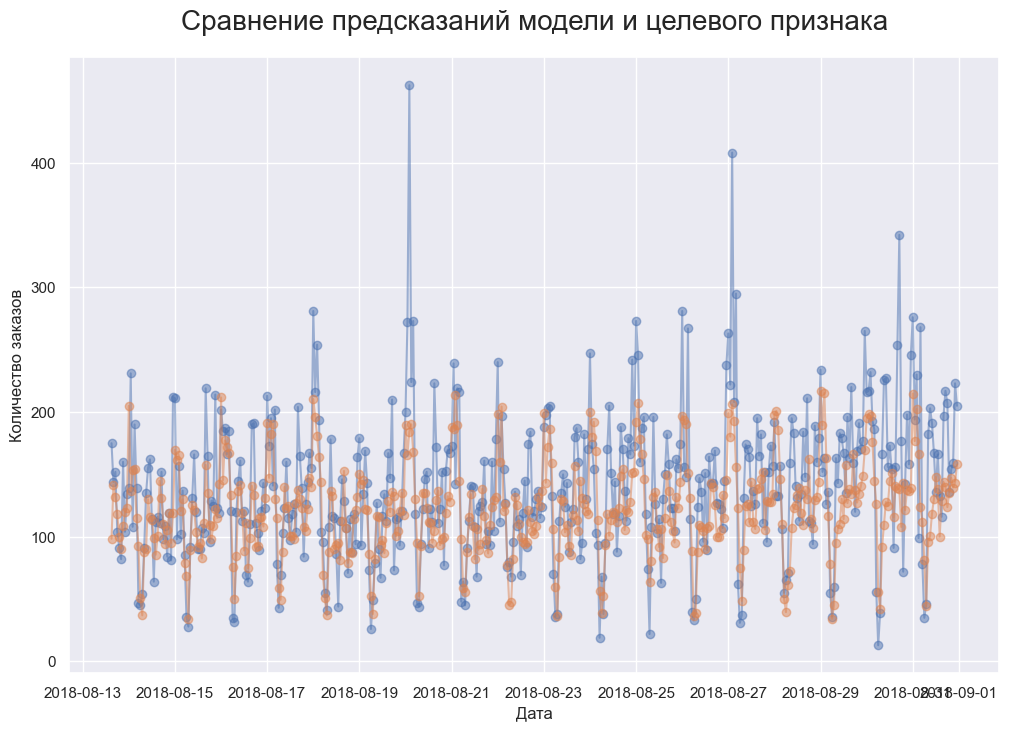

In [42]:
plt.figure(figsize=(12, 8))
plt.plot(target_test, 
         marker='o',
         alpha=0.5        
            )
plt.plot(lgbm_pred, 
         marker='o',
         alpha=0.5        
            )
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.title('Сравнение предсказаний модели и целевого признака',
          fontsize='20',
          pad=20
         )
plt.show() 

## Общий вывод

В данном проекте на основании исторических данных о заказах такси в аэропортах нам необходимо было построить модель для предсказания количества заказов на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**1 и 2 этапы**

- Ознакомились с имеющимися данными.
- Изменили тип столбца datetime на datetime.
- Проверили наличие дубликатов - они не были обнаружены. 
- Произвели ресемплинг по одному часу.
- Исследовали данные на предмет аномалий и выбросов и обработали их.
- Исследовали характер распределения данных.
- Создали несколько новых признаков, включая скользящее среднее и отстающие значения.
- Удалили появившиеся пропуски после создания признаков.
- Разделили датасет на обучающую и тестовую выборки в соотношении 9:1.

**3 этап**

В течение данного этапа мы обучили 4 типа моделей, которые показали следующие результаты:
- Дерево решений:
    - RMSE ~ 32,47.
- Случайный лес:
    - RMSE ~ 29,28.
- LGBM:
    - RMSE ~ 29,51.
- CatBoost:
    - RMSE ~ 30,37.

По результатам оценки метрики RMSE была выбрана модель LGBM.

**4 этап**

Выбранная модель была проверена на тестовой выборке.  
Был получен результат RMSE = 17,62, что укладывается в наш целевой показатель (<48).

Итого: задача проекта выполнена, а цель достигнута.

